# Load Activity Data

First we load the activity data of Bob, to do some exploratory analysis 

In [1]:
import os
import pandas as pd

pd.options.mode.chained_assignment = None 
pd.set_option('display.max_rows', 100)

In [2]:
CSV_PATH = os.path.join("..", "data", "activity_data.csv")

df_activity = pd.read_csv(CSV_PATH)

df_activity.head()

,Aktivitätstyp,Datum,Distanz,Kalorien,Zeit,Ø Herzfrequenz,Maximale Herzfrequenz,Aerober TE,Ø Schrittfrequenz (Laufen),Max. Schrittfrequenz (Laufen),Ø Geschwindigkeit,Maximale Geschwindigkeit,Positiver Höhenunterschied,Negativer Höhenunterschied,Ø Schrittlänge
0,Laufen,2020-08-22 11:13:16,3.82,269,0:20:47,138,150,2.4,160,174,5:26,4:05,55,67,1.15
1,Radfahren,2020-08-22 8:37:31,56.06,"1,178",2:30:09,119,143,2.6,--,--,22.4,47.9,448,461,0.00
2,Laufen,2020-08-20 7:40:48,11.36,678,1:02:41,135,155,2.8,160,192,5:31,3:32,124,116,1.13
3,Schwimmbadschwimmen,2020-08-19 8:17:18,"1,400",311,0:49:09,144,181,3.7,--,--,2:48,0:49,--,--,0.00
4,Laufen,2020-08-18 7:49:42,7.97,592,0:43:31,146,162,3.6,162,190,5:28,3:48,119,122,1.13


# Process Activity Data

In [3]:
import seaborn as sns
from matplotlib import pyplot as plt

import pylab
pylab.rcParams['figure.figsize'] = (12, 10)

%matplotlib inline

Transalte column names to English

In [5]:
column_translation = {
    "Aktivitätstyp": "Activity type",
    "Datum": "Date",
    "Distanz": "Distance",
    "Kalorien": "Calories",
    "Zeit": "Time",
    "Ø Herzfrequenz": "Hearth Rate",
    "Maximale Herzfrequenz": "Max Hearth Rate",
    "Aerober TE": "Aerobic TE",
    "Ø Schrittfrequenz (Laufen)": "Cadence (running)",
    "Max. Schrittfrequenz (Laufen)": "Max. Cadence (running)",
    "Ø Geschwindigkeit": "Speed",
    "Maximale Geschwindigkeit": "Maximum speed",
    "Positiver Höhenunterschied": "Positive difference in altitude",
    "Negativer Höhenunterschied": "Negative height difference",
    "Ø Schrittlänge": "Stride Length" 
}

df_activity = df_activity.rename(columns=column_translation)
df_activity.head()

,Activity type,Date,Distance,Calories,Time,Hearth Rate,Max Hearth Rate,Aerobic TE,Cadence (running),Max. Cadence (running),Speed,Maximum speed,Positive difference in altitude,Negative height difference,Stride Length
0,Laufen,2020-08-22 11:13:16,3.82,269,0:20:47,138,150,2.4,160,174,5:26,4:05,55,67,1.15
1,Radfahren,2020-08-22 8:37:31,56.06,"1,178",2:30:09,119,143,2.6,--,--,22.4,47.9,448,461,0.00
2,Laufen,2020-08-20 7:40:48,11.36,678,1:02:41,135,155,2.8,160,192,5:31,3:32,124,116,1.13
3,Schwimmbadschwimmen,2020-08-19 8:17:18,"1,400",311,0:49:09,144,181,3.7,--,--,2:48,0:49,--,--,0.00
4,Laufen,2020-08-18 7:49:42,7.97,592,0:43:31,146,162,3.6,162,190,5:28,3:48,119,122,1.13


## Some cleaning and processing

I noticed that some columns have different formats/scale depending on the activity type, so it could be useful to have them also normalized.

Moreover, i looks like there are a couple of trail runs with null distance and calories, probably they are simply errors to be dropped.

In [6]:
def preprocess_data(df):
    df_activity = df.copy()
    df_activity["Calories"] = pd.to_numeric(df_activity["Calories"].apply(lambda x: str(x).replace(",", ".")), errors='coerce')
    df_activity = df_activity.dropna(subset=["Calories"])
    
    df_activity["Distance"] = pd.to_numeric(df_activity["Distance"].apply(lambda x: str(x).replace(",", "")), errors='coerce')
    df_activity["Distance"][df_activity["Activity type"] == "Schwimmbadschwimmen"] = df_activity["Distance"] / 1000

    def seconds_from_time(x):
        parts = x.split(":")
        seconds = int(parts[0]) * 3600 + int(parts[1]) * 60 + int(parts[2])
        return seconds

    df_activity["Duration (s)"] = df_activity["Time"].apply(seconds_from_time)

    df_activity["Speed (km/h)"] = df_activity["Distance"] / df_activity["Duration (s)"] * 3600
    
    df_activity["Date"] = pd.to_datetime(df_activity["Date"])
    df_activity["date_day"] = df_activity["Date"].dt.date
    
    return df_activity
    

In [10]:
df_activity = preprocess_data(df_activity)
df_activity.head()

,Activity type,Date,Distance,Calories,Time,Hearth Rate,Max Hearth Rate,Aerobic TE,Cadence (running),Max. Cadence (running),Speed,Maximum speed,Positive difference in altitude,Negative height difference,Stride Length,Duration (s),Speed (km/h),date_day
0,Laufen,2020-08-22 11:13:16,3.82,269.000,0:20:47,138,150,2.4,160,174,5:26,4:05,55,67,1.15,1247,11.028067,2020-08-22
1,Radfahren,2020-08-22 08:37:31,56.06,1.178,2:30:09,119,143,2.6,--,--,22.4,47.9,448,461,0.00,9009,22.401598,2020-08-22
2,Laufen,2020-08-20 07:40:48,11.36,678.000,1:02:41,135,155,2.8,160,192,5:31,3:32,124,116,1.13,3761,10.873704,2020-08-20
3,Schwimmbadschwimmen,2020-08-19 08:17:18,1.40,311.000,0:49:09,144,181,3.7,--,--,2:48,0:49,--,--,0.00,2949,1.709054,2020-08-19
4,Laufen,2020-08-18 07:49:42,7.97,592.000,0:43:31,146,162,3.6,162,190,5:28,3:48,119,122,1.13,2611,10.988893,2020-08-18


## Plot some data

Here we have a quick overview of the distribution of some variables, also based on the activity type

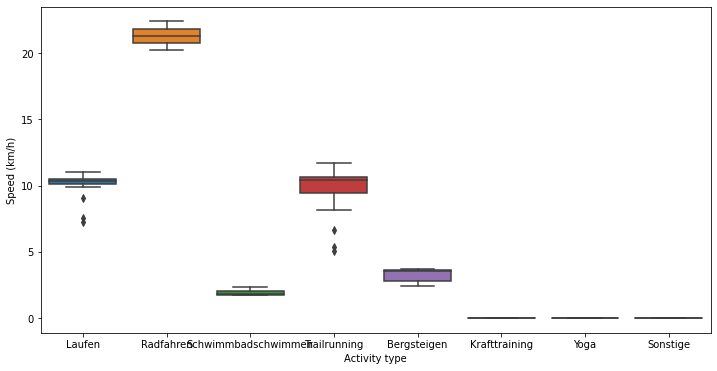

In [11]:
plt.figure(figsize=(12,6))
sns.boxplot(
    x="Activity type",
    y="Speed (km/h)",
    data=df_activity
)
plt.show()

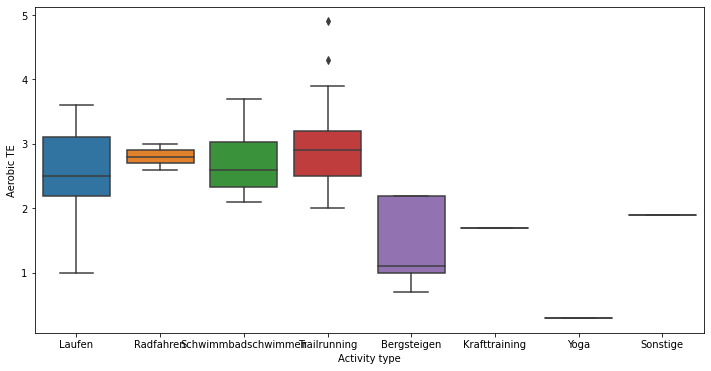

In [12]:
plt.figure(figsize=(12,6))
sns.boxplot(
    x="Activity type",
    y="Aerobic TE",
    data=df_activity
)
plt.show()

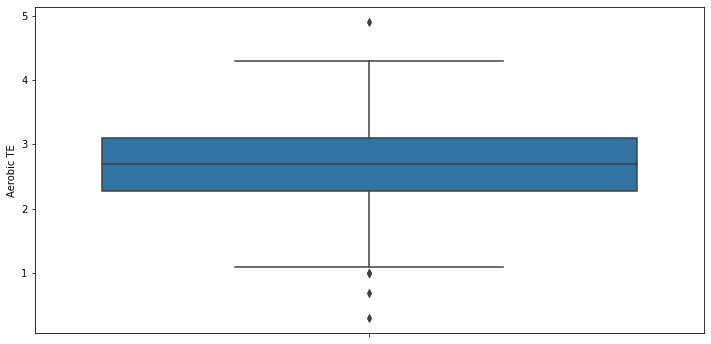

In [13]:
plt.figure(figsize=(12,6))
sns.boxplot(
    y="Aerobic TE",
    data=df_activity
)
plt.show()

In [14]:
df_activity["Aerobic TE"].describe()

count    76.000000
mean      2.655263
std       0.773631
min       0.300000
25%       2.275000
50%       2.700000
75%       3.100000
max       4.900000
Name: Aerobic TE, dtype: float64

# Assign a Label to the Activities 

In order to train a model, that is able to tell if one should rest or train, we need to have some labeled data.

For the sake of simplicity, we will assign a label of *True* (rest) for the activities where the aerobic training effect was in the lowest quartile.

This assumption allows us to distinguish between the cases in which the person was able to perform a good training and the ones in which he could have rest (some activities such as yoga will be included in the rest).

In [15]:
df_activity["label"] = df_activity["Aerobic TE"].apply(lambda x: float(x < 2.3))
df_activity["label"].describe()

count    76.00000
mean      0.25000
std       0.43589
min       0.00000
25%       0.00000
50%       0.00000
75%       0.25000
max       1.00000
Name: label, dtype: float64

# Get Bob's data from API

We get Bob HR data from the API.

For other users we will only have HR data, so this is the only source that we can use to train a model.

In [16]:
import requests

url = "https://hrv4roland.herokuapp.com/hrv/?name=Bob"

data = requests.get(url)

In [17]:
df_hr = pd.DataFrame(data.json()['data'])

df_hr["datetime"] = pd.to_datetime(df_hr["date"])

df_hr.head()

,date,hrpeak,hrrest,hrstanding,hrvrest,hrvstanding,datetime
0,22.08.2020 07:27,93,53,78,48,10,2020-08-22 07:27:00
1,21.08.2020 06:18,91,51,79,57,12,2020-08-21 06:18:00
2,20.08.2020 05:44,94,56,79,46,9,2020-08-20 05:44:00
3,19.08.2020 06:29,86,52,76,57,9,2020-08-19 06:29:00
4,18.08.2020 06:55,86,55,79,40,8,2020-08-18 06:55:00


In [18]:
df_dataset = pd.DataFrame()


for _, row in df_activity.iterrows():
    df_candidate = df_hr[df_hr["datetime"] < row["Date"]].sort_values(by="datetime", ascending=False)
    features = df_candidate.head(1)
    features["label"] = row["label"]
    features["activity"] = row["Activity type"]
    features["activity_date"] = row["Date"]
    df_dataset = df_dataset.append(features)
    
df_dataset = df_dataset.reset_index(drop=True)

df_dataset["hours_from_hr_to_activity"] = (df_dataset["activity_date"] - df_dataset["datetime"]).dt.seconds / 3600

df_dataset = df_dataset[["hrpeak", "hrrest", "hrstanding", "hrvrest", "hrvstanding", "hours_from_hr_to_activity", "label"]]

df_dataset.head()

,hrpeak,hrrest,hrstanding,hrvrest,hrvstanding,hours_from_hr_to_activity,label
0,93,53,78,48,10,3.771111,0.0
1,93,53,78,48,10,1.175278,0.0
2,94,56,79,46,9,1.946667,0.0
3,86,52,76,57,9,1.805000,0.0
4,86,55,79,40,8,0.911667,0.0


# Train a simple model

In [28]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix

In [19]:
feat_cols = ["hrpeak", "hrrest", "hrstanding", "hrvrest", "hrvstanding", "hours_from_hr_to_activity"]
label_col = "label"

In [54]:
X = df_dataset[feat_cols].values
y = df_dataset[label_col].values


parameters = {
    "max_depth": [3, 4, 5, 6], 
    "max_features": ["sqrt", "log2"],
    "min_samples_leaf": [1, 2, 3, 5],
}


tree = DecisionTreeClassifier(random_state=42)

clf = GridSearchCV(tree, parameters, cv=5, refit=True)

clf.fit(X, y)

y_pred = clf.predict(X)

model = clf.best_estimator_

clf.best_params_, clf.best_score_, f1_score(y, y_pred), precision_score(y, y_pred), recall_score(y, y_pred)

({'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 3},
 0.6841666666666667,
 0.6857142857142857,
 0.75,
 0.631578947368421)

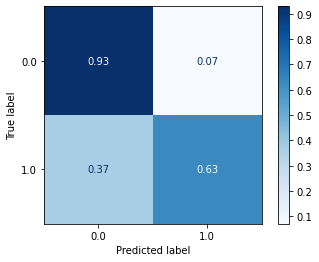

In [55]:
plot_confusion_matrix(model, X, y, cmap=plt.cm.Blues, normalize='true')
plt.show() 

In [56]:
from joblib import dump

filename = 'hr_model.joblib'
dump(model, open(filename, 'wb'))